In [143]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [144]:



transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



trainset = datasets.SVHN('data', split="train", download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.SVHN('data', split="test", download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=6128, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [145]:
image, label = next(iter(trainloader))
print(len(trainset))
print(len(testset))



73257
26032


In [146]:
image.shape
(image.view(image.shape[0],-1)).shape


torch.Size([128, 3072])

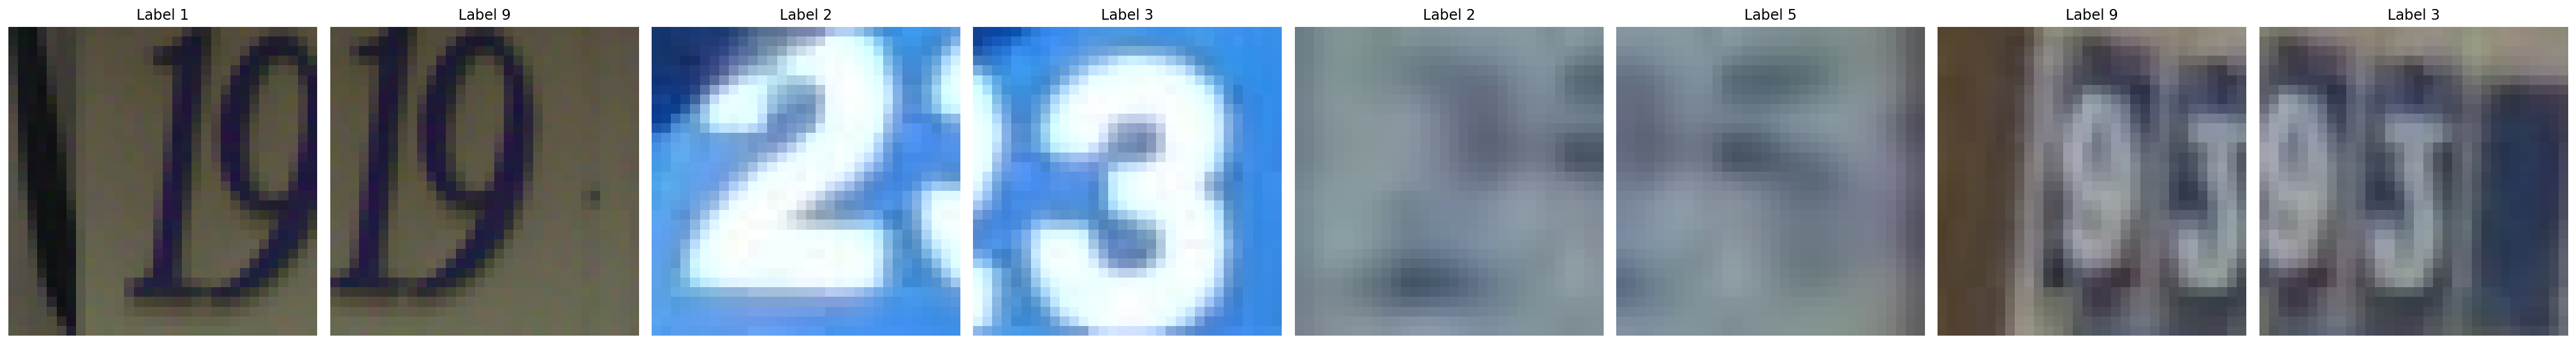

In [147]:
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(30, 4)
for i in range(8):
    img, lbl = trainset[i]
    img_disp = img.permute(1,2,0)
    ax[i].imshow(img_disp)
    ax[i].axis("off")
    ax[i].set_title(f"Label {lbl}")

plt.tight_layout()
plt.show()

In [152]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix




class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


In [165]:
model = Classifier()
model = model.to(device)

criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0
cm = [ [ 0 for i in range(10) ] for j in range(10) ]


train_losses, test_losses = [], []
# train_acc, test_acc =[],[]        
for e in range(epochs):
    running_loss = 0
    # accuracy2 = 0
    for images, labels in trainloader:
        images= images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        # with torch.no_grad(): 
        #   log_ps2 = log_ps.clone().detach()               
        #   ps2 = torch.exp(log_ps2)
        #   top_p2, top_class2 = ps2.topk(1, dim=1)
        #   equals2 = top_class2 == labels.view(*top_class2.shape)
        #   accuracy2 += torch.mean(equals.type(torch.FloatTensor))
        
        running_loss += loss.item()
 
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images= images.to(device)
                labels = labels.to(device)             
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                cm = confusion_matrix(labels.view(*top_class.shape).cpu(), top_class.cpu())
                

        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # train_acc.append(accuracy2/len(trainloader))
        # test_acc.append(accuracy/len(testloader))

        # print("Epoch: {}/{}.. ".format(e+1, epochs),
        #       "Training Loss: {:.3f}.. ".format(train_losses[-1]),
        #       "Train Accuracy: {:.3f}".format(accuracy2/len(trainloader)),
        #       "Test Loss: {:.3f}.. ".format(test_losses[-1]),
        #       "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))  
        print(cm)     

Epoch: 1/30..  Training Loss: 2.170..  Test Loss: 2.029..  Test Accuracy: 0.267
[[  0  14  75   0   0   0   0   0   0   0]
 [  0 266  70   0   0   0   0   0   0   0]
 [  0  84 156   0   0   0   0   0   0   0]
 [  0  48 112   0   0   0   0   0   0   0]
 [  0  98  26   0   0   0   0   0   0   0]
 [  0  39  97   0   0   0   0   0   0   0]
 [  0  22  94   0   0   0   0   0   0   0]
 [  0  61  71   0   0   0   0   0   0   0]
 [  0  27  70   0   0   0   0   0   0   0]
 [  0  18  72   0   0   0   0   0   0   0]]
Epoch: 2/30..  Training Loss: 1.799..  Test Loss: 1.668..  Test Accuracy: 0.444
[[ 17  14  17   7  15  23  13   0   0   1]
 [  3 203  13  15  19   8   3   4   2   0]
 [  3  36 164   6  15   7   4   5   1   0]
 [  3  23  36  68   8  14   5   0   0   0]
 [  6  14  10   1 115   3   5   0   0   0]
 [  9  22  10  23  11  49   9   0   1   0]
 [  9  15  22   5  26  16  23   1   2   0]
 [  1  26  66   9   4   2   4   8   1   0]
 [  6  22   9   8  25  32  11   0   3   0]
 [ 10  19  11  28  11 

In [166]:
import numpy as np
def view_classify(img, ps, version="SVHN"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "SVNH":
        ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

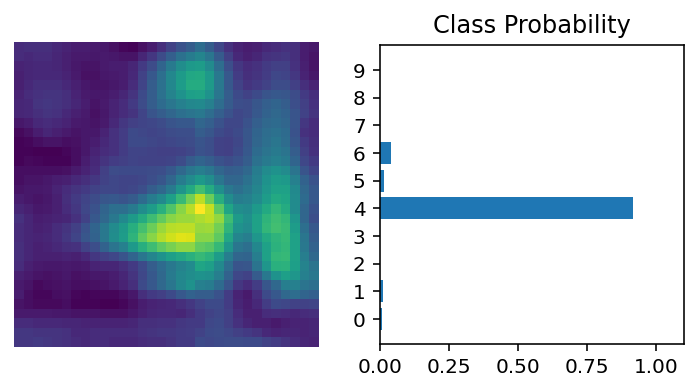

In [168]:
# Import helper module (should be in the repo)


# Test out your network!
model = model.cpu()
model.eval()


dataiter = iter(testloader)
images, labels = dataiter.next()
# images= images.to(device)
# labels = labels.to(device)
img = images[0]
# img =img.to(device)
# Convert 2D image to 1D vector
img = img.view(1, 3072)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
    # output=output.cpu()
ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps, version='SVNH')


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)



In [ ]:
# plt.plot(train_acc, label='Training accuracy')
# plt.plot(test_acc, label='Validation accuracy')
# plt.legend(frameon=False)